## 횡단보도 관리번호 별 사건 개수 컬럼 추가

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('dj_09_filtered_xy.xlsx')
print(df.columns)

Index(['acc_x', 'acc_y', '시도명', '시군구명', '도로명', '소재지도로명주소', '횡단보도관리번호',
       '횡단보도종류', '자전거횡단도겸용여부', '고원식적용여부', 'grsXCrd', 'grsYCrd', '차로수', '횡단보도폭',
       '횡단보도연장', '보행자신호등유무', '보행자작동신호기유무', '음향신호기설치여부', '녹색신호시간', '적색신호시간',
       '교통섬유무', '보도턱낮춤여부', '점자블록유무', '집중조명시설유무', '관리기관명', '관리기관전화번호',
       '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')


In [4]:
count_by_id = df['횡단보도관리번호'].value_counts()
print(count_by_id)

횡단보도관리번호
06-0000006457    8
06-0000006456    8
06-0000006455    8
06-0000006454    8
06-0000006453    7
                ..
06-0000003804    1
06-0000006570    1
06-0000006569    1
06-0000006568    1
06-0000031413    1
Name: count, Length: 207, dtype: int64


In [5]:
df['사건수'] = df['횡단보도관리번호'].map(count_by_id)

In [6]:
print(df[['녹색신호시간', '사건수']].isnull().sum())

녹색신호시간    281
사건수         0
dtype: int64


In [7]:
print(df.columns)

Index(['acc_x', 'acc_y', '시도명', '시군구명', '도로명', '소재지도로명주소', '횡단보도관리번호',
       '횡단보도종류', '자전거횡단도겸용여부', '고원식적용여부', 'grsXCrd', 'grsYCrd', '차로수', '횡단보도폭',
       '횡단보도연장', '보행자신호등유무', '보행자작동신호기유무', '음향신호기설치여부', '녹색신호시간', '적색신호시간',
       '교통섬유무', '보도턱낮춤여부', '점자블록유무', '집중조명시설유무', '관리기관명', '관리기관전화번호',
       '데이터기준일자', '제공기관코드', '제공기관명', '사건수'],
      dtype='object')


In [8]:
df.to_excel('dongjak_with_crosswalk_accident_count.xlsx')

## 상관계수 확인(피어슨, 스피어만)

In [9]:
df2 = pd.read_excel('dongjak_with_crosswalk_accident_count.xlsx')

In [10]:
from scipy.stats import pearsonr, spearmanr

In [11]:
df_valid = df2[['녹색신호시간', '사건수']].dropna()

In [12]:
print(df_valid.columns)

Index(['녹색신호시간', '사건수'], dtype='object')


In [13]:
print(df_valid['사건수'].dtype)
print(df_valid['녹색신호시간'].dtype)

int64
float64


In [14]:
pearsonr_corr, p_value1 = pearsonr(df_valid['녹색신호시간'], df_valid['사건수'])
spearmanr_corr, p_value2 = spearmanr(df_valid['녹색신호시간'], df_valid['사건수'])

In [15]:
print(df_valid['녹색신호시간'].nunique())
print(df_valid['사건수'].nunique())
print(df_valid['녹색신호시간'].head(10))
print(df_valid['사건수'].head(10))

25
6
0     33.0
2     27.0
5     31.0
7     32.0
25    28.0
26    30.0
27    25.0
30    30.0
34    27.0
40    26.0
Name: 녹색신호시간, dtype: float64
0     2
2     2
5     1
7     1
25    3
26    1
27    1
30    1
34    3
40    3
Name: 사건수, dtype: int64


In [16]:
print(f"피어슨 상관계수: {pearsonr_corr:.2f} (p={p_value1:.3f})")
print(f"스피어만 상관계수: {spearmanr_corr:.2f} (p={p_value2:.3f})")

피어슨 상관계수: -0.27 (p=0.002)
스피어만 상관계수: -0.21 (p=0.019)


## 가설에 대한 다중회귀분석

In [17]:
%pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import statsmodels.api as sm

In [19]:
print(df2['녹색신호시간'].dtypes)
print(df2['차로수'].dtypes)
print(df2['횡단보도폭'].dtypes)
print(df2['보행자신호등유무'].dtypes)
print(df2['집중조명시설유무'].dtypes)

float64
int64
float64
object
object


In [20]:
df_valid2 = df2[['녹색신호시간', '차로수', '횡단보도폭', '보행자신호등유무', '집중조명시설유무']].dropna()

In [21]:
X = df_valid2[['녹색신호시간','차로수','횡단보도폭', '보행자신호등유무', '집중조명시설유무']]
X = pd.get_dummies(X, drop_first=True) # 범주형 변수인 '보행자신호등유무', '집중조명시설유무' 컬럼 처리
X = X.astype(float) # 여전히 True/False 값으로 되어있어 숫자형으로 변환
X = sm.add_constant(X)
y = df_valid['사건수']

In [22]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    사건수   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5.667
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           0.000323
Time:                        19:54:20   Log-Likelihood:                -259.37
No. Observations:                 127   AIC:                             528.7
Df Residuals:                     122   BIC:                             543.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0503      0.903      4.484      0.0

# 랜덤포레스트 머신러닝

In [23]:
df_valid2['is_accident'] = (df_valid['사건수']>0).astype(int)
print(df_valid2.head(5))

    녹색신호시간  차로수  횡단보도폭 보행자신호등유무 집중조명시설유무  is_accident
0     33.0    4    6.2        Y        Y            1
2     27.0    6    5.5        Y        Y            1
5     31.0    4    6.0        Y        Y            1
7     32.0    4    6.4        Y        Y            1
25    28.0    6    6.6        Y        Y            1


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
# 랜덤포레스트 모델 정의
rf = RandomForestClassifier(n_estimators=100, random_state=2025)

In [26]:
y = df_valid2['is_accident']

# 교차검증 (K-Fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

In [27]:
# 랜덤포레스트 모델 정확도
print(f'RandomForestClassifier cv Accuray: {scores.mean():.3f}(std: {scores.std():.3f})')

RandomForestClassifier cv Accuray: 1.000(std: 0.000)


In [28]:
rf.fit(X, y)
importances = rf.feature_importances_
for name, imp in zip(X.columns, importances):
    print(f'{name}: {imp:.3f}')

const: 0.000
녹색신호시간: 0.000
차로수: 0.000
횡단보도폭: 0.000
집중조명시설유무_Y: 0.000


In [29]:
y_pred = rf.predict(X)
print('\n분류 리포트:')
print(classification_report(y, y_pred))
print('혼동 행렬:')
print(confusion_matrix(y, y_pred))


분류 리포트:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       127

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

혼동 행렬:
[[127]]


/Users/yeonsu/Desktop/hackerton_backend/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [30]:
%pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


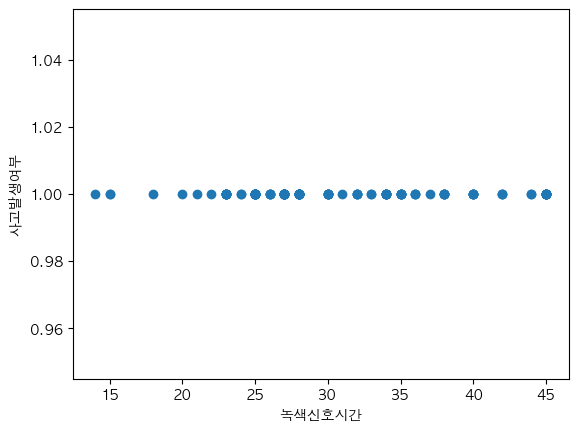

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'  # Mac 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스(-) 깨짐 방지
plt.scatter(df_valid2['녹색신호시간'], df_valid2['is_accident'])
plt.xlabel('녹색신호시간')
plt.ylabel('사고발생여부')
plt.show()

In [32]:
print(df_valid2['is_accident'].value_counts())

is_accident
1    127
Name: count, dtype: int64


### 여전히 데이터 불균형으로 인한 문제 발생...
- 동작구 횡단보도 데이터(127개)에서는 녹색신호시간 등 주요 변수로 사고 발생 여부를 100% 예측할 수 있었지만, 표본 수가 제한적이고 추가 데이터 확보가 불가능하므로 데이터 불균형으로 인한 일반화 예상
- 데이터 전처리를 다시 진행할 필요가 있음